<a href="https://colab.research.google.com/github/markjschmidt/PET_List/blob/main/MJS_Gemini_TOF_List_data_20250525.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## My Prompt to Gemini:

The Vereos PET LOR data I am trying to understand is contained in a .list binary file. I need to be able to read it and determine PET LOR endpoints and Time of Flight position data.


Note:  Gemini does not accept binary files to upload for review.



## 1. Understanding the .list File Structure

Overall Structure: Binary file (.list) containing headers followed by list mode data (events and control words).

## Byte Order: Big Endian
 is specified for headers and typically for list data (though the header has a field list_byte_order for confirmation, readlist.m assumes Big Endian for reading words).

## Headers:

## Listview Header:
 512 bytes. Contains basic info like nevents_per_buffer, magicNumber ('XTAL'), listtype (should be 16 for Crystal Acquisition format), and importantly, the sizes of the main and subheaders.

## Main Header:
 Variable size, indicated in Listview Header (typically 17 records * 512 bytes = 8704 bytes). Contains detailed scan, patient, and reconstruction parameters (Appendix A). The MATLAB script uses helper functions (imageio_getmhdr, imageio_getexhdr) which we'll need to replicate based on Appendix A's memory maps. Note the concept of the "Extended Main Header" which spans multiple 512-byte blocks.

## Sub Header:
 Variable size, indicated in Listview Header (typically 1 record * 512 bytes). Contains slice-specific information (Appendix B). The MATLAB script uses imageio_getshdr.

## Total Header Size:
 The headersize = 9744 bytes. This equals 512 (Listview) + 8704 (Main) + 512 (Sub) = 9728 bytes. There seems to be a small discrepancy (16 bytes) between the hardcoded 9744 and the sum 9728. Let's initially trust the 9744 based on the script's seek operation, but keep the individual component sizes in mind. Update: Looking closely at Chapter 3 again, it mentions the subheader is followed by deLength (64-bit/8 bytes), deType (16-bit/2 bytes), and dePad (16-bit/2 bytes). 8+2+2 = 12 bytes. 9728 + 12 = 9740. Still not 9744. Let's proceed with 9744 based on the script, assuming there might be 4 bytes of padding or an undocumented field.

## List Data: Starts after the headers (at byte 9744).

Consists of interleaved 32-bit "Data Words" and "Control Words".
XTAL Event Format (List Type 16): Each logical event consists of two 32-bit words.

##Word 1 (First Data Word):

Bits 31:30: 00 (Identifies First Data Word)

Bit 29: Delay Bit (1 = Delayed, 0 = Prompt)

Bit 28: Reserved (0)

Bits 27:20: Time of Flight (TOF) information (8 bits). Crucial for TOF positioning.

Bits 19:10: XPOS(B) - Crystal X index for detector B (10 bits)

Bits 9:0: XPOS(A) - Crystal X index for detector A (10 bits)

##Word 2 (Second Data Word):

Bits 31:30: 01 (Identifies Second Data Word)

Bits 29:23: Zb - Crystal Z index (axial) for detector B (7 bits)

Bits 22:16: Za - Crystal Z index (axial) for detector A (7 bits)

Bits 15:8: LEb - Local Energy for detector B (8 bits)

Bits 7:0: LEa - Local Energy for detector A (8 bits)


##Control Word Format: Each logical control word also consists of two 32-bit words (though the second might just be reserved padding).

Word 1 (First Control Word):

Bits 31:30: 10 (Identifies First Control Word)

Bits 29:27: CWT (Control Word Type) - See Appendix C/Manual Table 4.

Bits 26:0: CWINFO (Control Word Information) - Depends on CWT.

Word 2 (Second Control Word):

Bits 31:30: 11 (Identifies Second Control Word)

Bits 29:0: Reserved (0)


## 2. Analyzing .list files:

Goal: Reads headers and a specified number (ndataset) of raw 32-bit entries (pairs for XTAL) from the file, parses them into event (evt) and control (ctrl) arrays, and returns them along with header structures.

Headers: likely won't parse every field initially unless necessary.

Data Loop: Reads 32-bit unsigned integers (uint32) in Big Endian format.

Word Identification: Uses bit shifts and masks (bitshift, bitand) to check bits 31:30 to determine if a word is Control (10 or 11) or Data (00 or 01), and which word of the pair it is.

Field Extraction: Uses bit shifts (bitshift) and bitwise AND (bitand) with hexadecimal masks to isolate specific fields within the 32-bit words.

Output: Stores extracted data in separate ctrl and evt matrices. Uses an ind structure to provide named access to the rows (columns in NumPy) of these matrices.




## 3. Planning the Python Implementation

Libraries: struct (for unpacking binary data), numpy (for arrays, optional but good for large data), pathlib (for paths).

File Handling: Open the file in binary read mode ('rb').

Headers:

Read the first 512 bytes (Listview Header). Unpack key fields like listtype, mainheader_size, subheader_size using struct.unpack('>I', ...) etc. ('>' for Big Endian).

Read the Main Header (size indicated * 512 bytes).

Read the Sub Header (size indicated * 512 bytes). Store as raw bytes or parse minimally.

## Seek to the start of the list data (offset 9744).

Data Reading:

Loop ndataset times (or until EOF if ndataset is None).

Inside the loop, read two 32-bit words (struct.unpack('>II', file.read(8))).

Check the first word's top bits (word1 >> 30) to determine if it's a control word pair (0b10) or data word pair (0b00).

## Parsing:

If Data Word Pair:

Extract fields from word1: delay = (word1 >> 29) & 0x1, tof = (word1 >> 20) & 0xFF, xb = (word1 >> 10) & 0x3FF, xa = word1 & 0x3FF.

Extract fields from word2: zb = (word2 >> 23) & 0x7F, za = (word2 >> 16) & 0x7F, leb = (word2 >> 8) & 0xFF, lea = word2 & 0xFF.

Store these extracted values (xa, xb, za, zb, tof, delay, lea, leb) perhaps in a dictionary or a named tuple and append to an events list.

If Control Word Pair:

Extract fields from word1: cwt = (word1 >> 27) & 0x7, cwinfo = word1 & 0x7FFFFFF.

Store these (cwt, cwinfo) and append to a controls list. Ignore word2.

Return Value: Return the read headers (as bytes or basic parsed structures) and the lists of events and controls.




## 4. Python Code Implementation

In [ ]:
import struct
import numpy as np
from pathlib import Path
from collections import namedtuple
import sys

# Define named tuples for better organization
Event = namedtuple("Event", ["xa", "xb", "za", "zb", "tof", "delay", "lea", "leb", "dataset_num"])
Control = namedtuple("Control", ["cwt", "cwinfo", "dataset_num"])

def parse_headers(f):
    """Reads and performs basic parsing of headers."""
    headers = {}

    # --- Listview Header (512 bytes) ---
    f.seek(0)
    lv_header_bytes = f.read(512)
    if len(lv_header_bytes) < 512:
        raise EOFError("Could not read full Listview header.")

    # Unpack key Listview fields (Big Endian)
    # Offsets based on common structures, might need refinement based on exact Philips version
    # struct ListViewHeaderStruct { // Offsets assuming this struct starts at 0
    #   UINT32 numEventsPerBuf;       // 0
    #   UINT8 magicNumber[4];         // 4
    #   UINT32 listType;              // 8
    #   UINT8 singlesMode;            // 12
    #   UINT8 timeStampsInAuxDataFlag; // 13
    #   UINT16 mainHeaderSize;       // 14 (Size in 512-byte records)
    #   UINT16 subHeaderSize;        // 16 (Size in 512-byte records)
    #   char comment[494];            // 18
    # };
    headers['listview_header'] = lv_header_bytes
    try:
        _nevents_buffer, = struct.unpack('>I', lv_header_bytes[0:4])
        magic_bytes = struct.unpack('>4s', lv_header_bytes[4:8])[0]
        headers['magic_number'] = magic_bytes.decode('ascii', errors='ignore').strip('\x00')
        headers['list_type'], = struct.unpack('>I', lv_header_bytes[8:12])
        headers['main_header_records'], = struct.unpack('>H', lv_header_bytes[14:16])
        headers['sub_header_records'], = struct.unpack('>H', lv_header_bytes[16:18])
        print(f"Magic Number: {headers['magic_number']}, List Type: {headers['list_type']}")
        print(f"Main Header Records: {headers['main_header_records']}, Sub Header Records: {headers['sub_header_records']}")

        if headers['magic_number'] != 'XTAL':
             print(f"Warning: Magic number is '{headers['magic_number']}', expected 'XTAL'. File might not be Crystal Acquisition format.", file=sys.stderr)
        # We expect list_type 16 for XTAL
        if headers['list_type'] != 16:
             print(f"Warning: List type is {headers['list_type']}, expected 16 for XTAL format.", file=sys.stderr)

    except struct.error as e:
        print(f"Error unpacking Listview header: {e}", file=sys.stderr)
        headers['list_type'] = -1 # Indicate error
        headers['main_header_records'] = 0
        headers['sub_header_records'] = 0


    # --- Main Header ---
    main_header_size_bytes = headers['main_header_records'] * 512
    f.seek(512) # Main header starts after Listview
    headers['main_header'] = f.read(main_header_size_bytes)
    if len(headers['main_header']) < main_header_size_bytes:
         print("Warning: Could not read full Main header.", file=sys.stderr)

    # --- Sub Header ---
    sub_header_start = 512 + main_header_size_bytes
    sub_header_size_bytes = headers['sub_header_records'] * 512
    f.seek(sub_header_start)
    headers['sub_header'] = f.read(sub_header_size_bytes)
    if len(headers['sub_header']) < sub_header_size_bytes:
        print("Warning: Could not read full Sub header.", file=sys.stderr)

    # --- Calculate data start offset ---
    # Based on readlist.m seeking to 9744
    headers['data_start_offset'] = 9744
    # Or based on headers: 512 + main_header_size_bytes + sub_header_size_bytes + 12 (for deLength etc.) - Needs confirmation
    # calculated_offset = 512 + main_header_size_bytes + sub_header_size_bytes # + 12 ?
    # print(f"Calculated header size: {calculated_offset} bytes")
    print(f"Using data start offset: {headers['data_start_offset']} (based on MATLAB script)")

    return headers

def read_list_file(filepath, num_datasets_to_read=None):
    """
    Reads a Philips PET XTAL list mode file (.list).

    Args:
        filepath (str or Path): Path to the .list file.
        num_datasets_to_read (int, optional): Number of 8-byte datasets (event or control pairs)
                                             to read. Reads all if None. Defaults to None.

    Returns:
        tuple: (headers, events, controls)
               headers (dict): Dictionary containing header bytes and basic parsed info.
               events (list): List of Event named tuples containing parsed event data.
               controls (list): List of Control named tuples containing parsed control data.
    """
    filepath = Path(filepath)
    events = []
    controls = []
    headers = {}

    # Bit masks (matching readlist.m and manual)
    MASK_WORD_TYPE = 0b11 << 30  # Check bits 31:30
    TYPE_FIRST_DATA = 0b00 << 30
    TYPE_SECOND_DATA = 0b01 << 30
    TYPE_FIRST_CTRL = 0b10 << 30
    TYPE_SECOND_CTRL = 0b11 << 30

    MASK_DELAY = 0x1
    MASK_TOF = 0xFF
    MASK_X = 0x3FF # 10 bits
    MASK_Z = 0x7F  # 7 bits
    MASK_E = 0xFF  # 8 bits
    MASK_CWT = 0x7
    MASK_CWINFO = 0x7FFFFFF

    SHIFT_DELAY_1 = 29
    SHIFT_TOF_1 = 20
    SHIFT_XB_1 = 10
    SHIFT_ZA_2 = 16
    SHIFT_ZB_2 = 23
    SHIFT_LEA_2 = 0
    SHIFT_LEB_2 = 8
    SHIFT_CWT_1 = 27


    try:
        with open(filepath, 'rb') as f:
            headers = parse_headers(f)
            list_type = headers.get('list_type', -1)

            if list_type != 16:
                 print(f"File list type is {list_type}, this parser specifically handles type 16 (XTAL). Results may be incorrect.", file=sys.stderr)
                 # Optionally raise an error here if strict type checking is needed
                 # raise ValueError(f"Unsupported list type: {list_type}. Expected 16.")


            data_start = headers.get('data_start_offset', 9744)
            f.seek(data_start)

            dataset_count = 0
            while True:
                # Check if we need to limit reading
                if num_datasets_to_read is not None and dataset_count >= num_datasets_to_read:
                    break

                # Read one dataset (two 32-bit words = 8 bytes)
                data_chunk = f.read(8)
                if len(data_chunk) < 8:
                    break # End of file or incomplete dataset

                # Unpack as two big-endian unsigned 32-bit integers
                word1, word2 = struct.unpack('>II', data_chunk)
                dataset_count += 1

                # Determine word type using bits 31:30 of the *first* word
                word1_type = word1 & MASK_WORD_TYPE

                if word1_type == TYPE_FIRST_DATA:
                    # --- Event Data Pair ---
                    # Sanity check: word2 should be TYPE_SECOND_DATA
                    word2_type = word2 & MASK_WORD_TYPE
                    if word2_type != TYPE_SECOND_DATA:
                        print(f"Warning: Data Word 1 followed by unexpected Word 2 type ({word2_type:#010x}) at dataset {dataset_count}", file=sys.stderr)
                        continue # Skip this malformed pair

                    # Parse Word 1
                    delay = (word1 >> SHIFT_DELAY_1) & MASK_DELAY
                    tof = (word1 >> SHIFT_TOF_1) & MASK_TOF
                    xb = (word1 >> SHIFT_XB_1) & MASK_X
                    xa = word1 & MASK_X

                    # Parse Word 2
                    zb = (word2 >> SHIFT_ZB_2) & MASK_Z
                    za = (word2 >> SHIFT_ZA_2) & MASK_Z
                    leb = (word2 >> SHIFT_LEB_2) & MASK_E
                    lea = word2 & MASK_E # No shift needed

                    events.append(Event(xa=xa, xb=xb, za=za, zb=zb, tof=tof, delay=delay, lea=lea, leb=leb, dataset_num=dataset_count))

                elif word1_type == TYPE_FIRST_CTRL:
                     # --- Control Word Pair ---
                     # Sanity check: word2 should be TYPE_SECOND_CTRL
                    word2_type = word2 & MASK_WORD_TYPE
                    if word2_type != TYPE_SECOND_CTRL:
                         print(f"Warning: Control Word 1 followed by unexpected Word 2 type ({word2_type:#010x}) at dataset {dataset_count}", file=sys.stderr)
                         continue # Skip this malformed pair

                    # Parse Word 1
                    cwt = (word1 >> SHIFT_CWT_1) & MASK_CWT
                    cwinfo = word1 & MASK_CWINFO
                    controls.append(Control(cwt=cwt, cwinfo=cwinfo, dataset_num=dataset_count))
                    # Word 2 is reserved/ignored for control words per manual/MATLAB

                else:
                    # This case should ideally not happen if word1_type is based on bits 31:30
                    print(f"Warning: Unexpected first word type {word1_type:#010x} at dataset {dataset_count}", file=sys.stderr)
                    continue # Skip this pair

    except FileNotFoundError:
        print(f"Error: File not found at {filepath}", file=sys.stderr)
    except EOFError as e:
         print(f"Error: Reached end of file unexpectedly. {e}", file=sys.stderr)
    except Exception as e:
        print(f"An unexpected error occurred: {e}", file=sys.stderr)

    print(f"Read {dataset_count} datasets. Found {len(events)} events and {len(controls)} control words.")
    return headers, events, controls

# --- Example Usage ---
if __name__ == "__main__":
    # Replace with the actual path to your .list file
    # list_file_path = Path("path/to/your/pet_data.list")
    # Example using a placeholder - replace this
    # list_file_path = Path("./example_pet.list") # Create a dummy file or use a real one
    # list_file_path = Path('/content/1SEC_CTAC.list')

    list_file_path = Path('/content/Center_Emiss_4794.list')


    # Create a dummy file for testing if it doesn't exist
    if not list_file_path.exists():
        print(f"Creating dummy file: {list_file_path}")
        try:
            # Create basic valid-looking headers (XTAL, 17 main, 1 sub)
            # Note: The actual content of main/sub headers isn't critical for basic parsing
            dummy_header = bytearray(9744)
            struct.pack_into('>I', dummy_header, 0, 1000) # nevents_buffer (dummy)
            struct.pack_into('>4s', dummy_header, 4, b'XTAL') # magicNumber
            struct.pack_into('>I', dummy_header, 8, 16) # listType = XTAL
            struct.pack_into('>H', dummy_header, 14, 17) # mainHeaderSize = 17 records
            struct.pack_into('>H', dummy_header, 16, 1) # subHeaderSize = 1 record

            # Create some dummy event data pairs (word1, word2)
            # Event 1: Prompt, TOF=128, XA=10, XB=20, ZA=5, ZB=6, LEA=100, LEB=110
            w1_evt1 = (TYPE_FIRST_DATA) | (0 << SHIFT_DELAY_1) | (128 << SHIFT_TOF_1) | (20 << SHIFT_XB_1) | 10
            w2_evt1 = (TYPE_SECOND_DATA) | (6 << SHIFT_ZB_2) | (5 << SHIFT_ZA_2) | (110 << SHIFT_LEB_2) | 100
            # Event 2: Delayed, TOF=130, XA=15, XB=25, ZA=7, ZB=8, LEA=105, LEB=115
            w1_evt2 = (TYPE_FIRST_DATA) | (1 << SHIFT_DELAY_1) | (130 << SHIFT_TOF_1) | (25 << SHIFT_XB_1) | 15
            w2_evt2 = (TYPE_SECOND_DATA) | (8 << SHIFT_ZB_2) | (7 << SHIFT_ZA_2) | (115 << SHIFT_LEB_2) | 105
             # Control 1: Timestamp (CWT=0), time=1234567 ms
            w1_ctrl1 = (TYPE_FIRST_CTRL) | (0 << SHIFT_CWT_1) | 1234567
            w2_ctrl1 = (TYPE_SECOND_CTRL) # Reserved bits are 0

            with open(list_file_path, 'wb') as f:
                f.write(dummy_header)
                f.write(struct.pack('>II', w1_evt1, w2_evt1))
                f.write(struct.pack('>II', w1_ctrl1, w2_ctrl1))
                f.write(struct.pack('>II', w1_evt2, w2_evt2))

        except Exception as e:
            print(f"Failed to create dummy file: {e}")
            sys.exit(1)

    # Read only the first 10 datasets (or all if file is smaller)
    # Set num_datasets_to_read=None to read the entire file
    headers, events, controls = read_list_file(list_file_path, num_datasets_to_read=10)

    if events:
        print("\n--- First 5 Events ---")
        for i, event in enumerate(events[:5]):
            print(f"Event {i+1} (Dataset {event.dataset_num}):")
            print(f"  LOR Endpoints: XA={event.xa}, XB={event.xb}, ZA={event.za}, ZB={event.zb}")
            print(f"  TOF Bin: {event.tof}, Delayed: {bool(event.delay)}")
            # print(f"  Energy: LEA={event.lea}, LEB={event.leb}") # Less critical for LOR/TOF

    if controls:
        print("\n--- First 5 Control Words ---")
        for i, control in enumerate(controls[:5]):
             print(f"Control {i+1} (Dataset {control.dataset_num}):")
             print(f"  Type (CWT): {control.cwt}, Info (CWINFO): {control.cwinfo}")
             # You would look up CWT in Appendix C/Table 4 to interpret CWINFO
             if control.cwt == 0: # Example: Elapsed Time Stamp
                 print(f"    (Timestamp: {control.cwinfo} ms)")
             elif control.cwt == 1: # Example: Table Position
                 print(f"    (Table Position: {control.cwinfo / 10.0} mm)") # Info is in tenths of mm


    # Example: Accessing specific data for the first event
    if events:
        first_event = events[0]
        print("\n--- Accessing First Event Data ---")
        print(f"XA: {first_event.xa}")
        print(f"XB: {first_event.xb}")
        print(f"ZA: {first_event.za}")
        print(f"ZB: {first_event.zb}")
        print(f"TOF: {first_event.tof}")

    # If using NumPy for analysis later:
    # event_array = np.array([(e.xa, e.xb, e.za, e.zb, e.tof, e.delay) for e in events],
    #                        dtype=[('xa', 'u2'), ('xb', 'u2'), ('za', 'u1'), ('zb', 'u1'), ('tof', 'u1'), ('delay', 'bool')])
    # print("\n--- Event Data as NumPy Array (first 5 rows) ---")
    # print(event_array[:5])



Magic Number: Xtal, List Type: 16
Main Header Records: 8704, Sub Header Records: 512
Using data start offset: 9744 (based on MATLAB script)
Read 10 datasets. Found 3 events and 0 control words.

--- First 5 Events ---
Event 1 (Dataset 3):
  LOR Endpoints: XA=15, XB=634, ZA=124, ZB=118
  TOF Bin: 111, Delayed: False
Event 2 (Dataset 5):
  LOR Endpoints: XA=15, XB=110, ZA=1, ZB=119
  TOF Bin: 205, Delayed: False
Event 3 (Dataset 8):
  LOR Endpoints: XA=15, XB=21, ZA=121, ZB=124
  TOF Bin: 221, Delayed: False

--- Accessing First Event Data ---
XA: 15
XB: 634
ZA: 124
ZB: 118
TOF: 111


In [ ]:
# If using NumPy for analysis later:
event_array = np.array([(e.xa, e.xb, e.za, e.zb, e.tof, e.delay) for e in events],
                        dtype=[('xa', 'u2'), ('xb', 'u2'), ('za', 'u1'), ('zb', 'u1'), ('tof', 'u1'), ('delay', 'bool')])
print("\n--- Event Data as NumPy Array (first 5 rows) ---")
print(event_array[:5])


--- Event Data as NumPy Array (first 5 rows) ---
[(15, 634, 124, 118, 111, False) (15, 110,   1, 119, 205, False)
 (15,  21, 121, 124, 221, False)]


NameError: name 'event_array' is not defined

## Explanation and Key Points:

Dependencies: Imports struct for binary data, numpy (optional, commented out usage), pathlib for file paths, collections.namedtuple for structured event/control data, and sys.

Named Tuples: Event and Control named tuples are defined to make accessing the parsed data fields much clearer (e.g., event.xa, control.cwt) compared to using numerical indices. The dataset_num field is added to track the original position in the file sequence.

parse_headers Function:

Reads the Listview header (first 512 bytes).

Unpacks essential fields (magic_number, list_type, main_header_records, sub_header_records) using Big Endian format (>). Error handling is included.

Prints warnings if the magic number or list type don't match the expected XTAL format.

Reads the main and subheader blocks based on the sizes indicated in the Listview header. Currently stores them as raw bytes. Full parsing would require implementing logic based on Appendices A and B.

Determines the data_start_offset (hardcoded to 9744 based on readlist.m's seek).

Returns a dictionary containing the raw header bytes and some key parsed values.

## read_list_file Function:

Opens the file in binary read mode ('rb').

Calls parse_headers to handle the header section.

Defines bit masks and shift values corresponding to the XTAL format specification and the MATLAB code.

Seeks to the start of the list data.

Enters a loop to read data:

Reads 8 bytes at a time (one dataset pair).

Breaks if EOF is reached or num_datasets_to_read limit is hit.

Unpacks the 8 bytes into two 32-bit unsigned integers (word1, word2).

Checks word1's top 2 bits (word1 >> 30) to determine if it's the start of a Data pair (0b00) or Control pair (0b10).

Includes sanity checks to ensure the second word (word2) has the expected type identifier (0b01 for data, 0b11 for control).

##Data Parsing:

 If it's a data pair, it applies the appropriate bit shifts and masks to extract delay, tof, xb, xa, zb, za, leb, lea.

 Appends an Event named tuple to the events list.

Control Parsing:
If it's a control pair, it extracts cwt and cwinfo from word1. Appends a Control named tuple to the controls list. word2 is ignored.

Includes basic error handling (FileNotFoundError, EOFError, general Exception).

Prints summary statistics.

Returns the headers dictionary, events list, and controls list.



## Revised Code:


In [ ]:
import struct
import numpy as np
from pathlib import Path
from collections import namedtuple
import sys
import pandas as pd # Import pandas

# Define named tuples for better organization
# Simplified Event tuple for just LOR/TOF data
Event = namedtuple("Event", ["xa", "xb", "za", "zb", "tof", "delay", "read_index"])

def parse_headers_fixed(f):
    """Reads headers assuming fixed sizes based on MATLAB script comments."""
    headers = {}
    # Assume sizes based on MATLAB comments/seeks
    LISTVIEW_SIZE = 512
    MAIN_HEADER_RECORDS = 17
    SUB_HEADER_RECORDS = 1
    MAIN_HEADER_SIZE = MAIN_HEADER_RECORDS * 512
    SUB_HEADER_SIZE = SUB_HEADER_RECORDS * 512
    # Use offset from MATLAB script directly
    DATA_START_OFFSET = 9744

    # --- Listview Header ---
    f.seek(0)
    lv_header_bytes = f.read(LISTVIEW_SIZE)
    if len(lv_header_bytes) < LISTVIEW_SIZE:
        raise EOFError("Could not read full Listview header.")
    headers['listview_header'] = lv_header_bytes
    try:
        magic_bytes = struct.unpack('>4s', lv_header_bytes[4:8])[0]
        # Allow 'Xtal' or 'XTAL'
        magic_str = magic_bytes.decode('ascii', errors='ignore').strip('\x00')
        headers['magic_number'] = magic_str
        if magic_str.upper() != 'XTAL':
            print(f"Warning: Magic number is '{magic_str}', expected 'XTAL' or 'Xtal'.", file=sys.stderr)

        headers['list_type'], = struct.unpack('>I', lv_header_bytes[8:12])
        if headers['list_type'] != 16:
            print(f"Warning: List type is {headers['list_type']}, expected 16 for XTAL format.", file=sys.stderr)
            # raise ValueError(f"Unsupported list type: {headers['list_type']}. Expected 16.")

        # We are ignoring the potentially incorrect size fields read from bytes 14-17
        print(f"Magic Number: {headers['magic_number']}, List Type: {headers['list_type']}")
        print(f"Assuming Main Header: {MAIN_HEADER_RECORDS} records ({MAIN_HEADER_SIZE} bytes)")
        print(f"Assuming Sub Header: {SUB_HEADER_RECORDS} record ({SUB_HEADER_SIZE} bytes)")

    except struct.error as e:
        print(f"Error unpacking Listview header: {e}", file=sys.stderr)
        headers['list_type'] = -1 # Indicate error

    # --- Read Headers (as raw bytes based on assumed sizes) ---
    f.seek(LISTVIEW_SIZE)
    headers['main_header'] = f.read(MAIN_HEADER_SIZE)
    if len(headers['main_header']) < MAIN_HEADER_SIZE:
         print("Warning: Could not read full assumed Main header.", file=sys.stderr)

    f.seek(LISTVIEW_SIZE + MAIN_HEADER_SIZE)
    headers['sub_header'] = f.read(SUB_HEADER_SIZE)
    if len(headers['sub_header']) < SUB_HEADER_SIZE:
        print("Warning: Could not read full assumed Sub header.", file=sys.stderr)

    headers['data_start_offset'] = DATA_START_OFFSET
    print(f"Using data start offset: {headers['data_start_offset']} (based on MATLAB script)")

    return headers


def read_list_file_events_only(filepath, num_words_to_read=None):
    """
    Reads a Philips PET XTAL list mode file (.list) focusing on events.
    Reads word by word to handle potential non-pair structure.

    Args:
        filepath (str or Path): Path to the .list file.
        num_words_to_read (int, optional): Max number of 4-byte words to read
                                           from the data section. Reads all if None.

    Returns:
        tuple: (headers, events)
               headers (dict): Dictionary containing header bytes and basic parsed info.
               events (list): List of Event named tuples containing parsed event data.
    """
    filepath = Path(filepath)
    events = []
    headers = {}
    temp_event_data = {} # To store parts of an event across reads

    # Bit masks
    MASK_WORD_TYPE = 0b11 << 30
    TYPE_FIRST_DATA = 0b00 << 30
    TYPE_SECOND_DATA = 0b01 << 30
    TYPE_FIRST_CTRL = 0b10 << 30
    TYPE_SECOND_CTRL = 0b11 << 30 # We'll ignore control words

    MASK_DELAY = 0x1
    MASK_TOF = 0xFF
    MASK_X = 0x3FF
    MASK_Z = 0x7F
    MASK_E = 0xFF

    SHIFT_DELAY_1 = 29
    SHIFT_TOF_1 = 20
    SHIFT_XB_1 = 10
    SHIFT_ZA_2 = 16
    SHIFT_ZB_2 = 23
    SHIFT_LEA_2 = 0
    SHIFT_LEB_2 = 8

    try:
        with open(filepath, 'rb') as f:
            headers = parse_headers_fixed(f) # Use the fixed size header parsing
            list_type = headers.get('list_type', -1)

            if list_type != 16:
                 print(f"File list type is {list_type}, parser expects 16 (XTAL).", file=sys.stderr)
                 # return headers, [] # Optionally exit early

            data_start = headers.get('data_start_offset', 9744)
            f.seek(data_start)

            word_count = 0
            while True:
                # Check if we need to limit reading
                if num_words_to_read is not None and word_count >= num_words_to_read:
                    break

                # Read one 32-bit word (4 bytes)
                data_chunk = f.read(4)
                if len(data_chunk) < 4:
                    break # End of file

                # Unpack as one big-endian unsigned 32-bit integer
                word, = struct.unpack('>I', data_chunk)
                word_count += 1
                current_read_index = word_count # Track position

                # Determine word type
                word_type = word & MASK_WORD_TYPE

                if word_type == TYPE_FIRST_DATA:
                    # --- Start of an Event ---
                    # If we were already expecting a second word, something is wrong
                    if temp_event_data:
                         print(f"Warning: Started new event (Word Type 00) at index {current_read_index} while expecting second data word for event started at {temp_event_data.get('read_index', 'N/A')}.", file=sys.stderr)
                         temp_event_data = {} # Discard incomplete previous event

                    # Parse Word 1 and store temporarily
                    temp_event_data['delay'] = (word >> SHIFT_DELAY_1) & MASK_DELAY
                    temp_event_data['tof'] = (word >> SHIFT_TOF_1) & MASK_TOF
                    temp_event_data['xb'] = (word >> SHIFT_XB_1) & MASK_X
                    temp_event_data['xa'] = word & MASK_X
                    temp_event_data['read_index'] = current_read_index # Store where this event started

                elif word_type == TYPE_SECOND_DATA:
                     # --- Second Word of an Event ---
                     # Check if we were expecting it
                    if not temp_event_data:
                        print(f"Warning: Found second data word (Word Type 01) at index {current_read_index} without seeing a first data word first.", file=sys.stderr)
                        continue # Skip this word

                    # Parse Word 2
                    zb = (word >> SHIFT_ZB_2) & MASK_Z
                    za = (word >> SHIFT_ZA_2) & MASK_Z
                    # lea = word & MASK_E
                    # leb = (word >> SHIFT_LEB_2) & MASK_E

                    # Combine with stored first word data and append
                    events.append(Event(xa=temp_event_data['xa'],
                                        xb=temp_event_data['xb'],
                                        za=za,
                                        zb=zb,
                                        tof=temp_event_data['tof'],
                                        delay=temp_event_data['delay'],
                                        read_index=temp_event_data['read_index']))
                    temp_event_data = {} # Clear temporary storage

                # Ignore Control Words (TYPE_FIRST_CTRL and TYPE_SECOND_CTRL)
                elif word_type == TYPE_FIRST_CTRL or word_type == TYPE_SECOND_CTRL:
                     # If we were expecting a second data word, log an error
                     if temp_event_data:
                          print(f"Warning: Found control word (Type {word_type>>30}) at index {current_read_index} while expecting second data word for event started at {temp_event_data.get('read_index', 'N/A')}.", file=sys.stderr)
                          temp_event_data = {} # Discard incomplete event
                     pass # Just ignore control words

                else:
                    # Should not happen with 2-bit type field
                     print(f"Warning: Unexpected word type {word_type:#010x} at index {current_read_index}", file=sys.stderr)
                     if temp_event_data: # Discard partial event if waiting for word 2
                          temp_event_data = {}


    except FileNotFoundError:
        print(f"Error: File not found at {filepath}", file=sys.stderr)
    except EOFError as e:
         print(f"Error: Reached end of file unexpectedly. {e}", file=sys.stderr)
    except Exception as e:
        print(f"An unexpected error occurred: {e}", file=sys.stderr)

    if temp_event_data:
         print(f"Warning: File ended while waiting for second data word for event started at index {temp_event_data.get('read_index', 'N/A')}.", file=sys.stderr)

    print(f"Read {word_count} words. Found {len(events)} complete events.")
    return headers, events

# --- Example Usage ---
if __name__ == "__main__":
    #list_file_path = Path("/content/1SEC_CTAC.list")
    #list_file_path = Path('/content/QA_Src_Offset_CTAC.list')
    list_file_path = Path('/content/Center_Emiss_4794.list')

    # Read first 1 million words (adjust as needed, None for all)
    # Reading word-by-word is slower, so limit for testing
    MAX_WORDS = 1000000
    headers, events = read_list_file_events_only(list_file_path, num_words_to_read=MAX_WORDS)

    if events:
        print(f"\n--- First 5 Events (out of {len(events)} found) ---")
        for i, event in enumerate(events[:5]):
            print(f"Event {i+1} (Started at word {event.read_index}):")
            print(f"  LOR Endpoints: XA={event.xa}, XB={event.xb}, ZA={event.za}, ZB={event.zb}")
            print(f"  TOF Bin: {event.tof}, Delayed: {bool(event.delay)}")

        # --- Create Pandas DataFrame ---
        print("\nCreating Pandas DataFrame...")
        try:
            # Convert list of named tuples to DataFrame
            df_events = pd.DataFrame(events)
            print("DataFrame created successfully.")
            print("\n--- DataFrame Head ---")
            print(df_events.head())
            print("\n--- DataFrame Info ---")
            df_events.info()
            # Example: Access TOF data
            # print("\n--- TOF Data (first 10) ---")
            # print(df_events['tof'].head(10))
        except Exception as e:
             print(f"Error creating DataFrame: {e}")

    else:
        print("\nNo complete events found in the processed words.")


Magic Number: Xtal, List Type: 16
Assuming Main Header: 17 records (8704 bytes)
Assuming Sub Header: 1 record (512 bytes)
Using data start offset: 9744 (based on MATLAB script)


Streaming output truncated to the last 5000 lines.


Read 1000000 words. Found 80343 complete events.

--- First 5 Events (out of 80343 found) ---
Event 1 (Started at word 5):
  LOR Endpoints: XA=15, XB=634, ZA=124, ZB=118
  TOF Bin: 111, Delayed: False
Event 2 (Started at word 9):
  LOR Endpoints: XA=15, XB=110, ZA=1, ZB=119
  TOF Bin: 205, Delayed: False
Event 3 (Started at word 15):
  LOR Endpoints: XA=15, XB=21, ZA=121, ZB=124
  TOF Bin: 221, Delayed: False
Event 4 (Started at word 21):
  LOR Endpoints: XA=0, XB=25, ZA=1, ZB=101
  TOF Bin: 7, Delayed: False
Event 5 (Started at word 47):
  LOR Endpoints: XA=271, XB=309, ZA=9, ZB=127
  TOF Bin: 144, Delayed: True

Creating Pandas DataFrame...
DataFrame created successfully.

--- DataFrame Head ---
    xa   xb   za   zb  tof  delay  read_index
0   15  634  124  118  111      0           5
1   15  110    1  119  205      0           9
2   15   21  121  124  221      0          15
3    0   25    1  101    7      0          21
4  271  309    9  127  144      1          47

--- DataFrame In

In [ ]:
df_events

,xa,xb,za,zb,tof,delay,read_index
0,150,0,87,82,0,0,1
1,150,0,87,80,0,0,3
2,150,0,87,78,0,0,5
3,150,0,87,76,0,0,7
4,150,0,87,74,0,0,9
...,...,...,...,...,...,...,...
100841,780,560,123,118,244,0,999969
100842,266,273,2,123,127,1,999973
100843,779,565,3,119,72,1,999987
100844,10,37,119,122,226,0,999993


In [ ]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100846 entries, 0 to 100845
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   xa          100846 non-null  int64
 1   xb          100846 non-null  int64
 2   za          100846 non-null  int64
 3   zb          100846 non-null  int64
 4   tof         100846 non-null  int64
 5   delay       100846 non-null  int64
 6   read_index  100846 non-null  int64
dtypes: int64(7)
memory usage: 5.4 MB


In [ ]:
df_events[1600:1632]

,xa,xb,za,zb,tof,delay,read_index
1600,150,0,67,6,0,0,12951
1601,150,0,67,4,0,0,12953
1602,780,28,4,121,212,0,12967
1603,781,44,126,112,112,0,12973
1604,150,0,67,2,0,0,12975
1605,266,297,124,104,196,1,12977
1606,778,316,113,106,110,0,12987
1607,150,0,67,0,0,0,12989
1608,10,13,0,127,210,0,12995
1609,523,517,121,120,213,1,12999


In [ ]:
df_events[16:32]


,xa,xb,za,zb,tof,delay,read_index
16,0,862,124,126,139,0,297
17,14,561,10,125,253,0,301
18,271,25,9,121,193,1,311
19,15,382,124,126,58,0,327
20,0,781,4,111,38,0,331
21,0,773,0,119,38,0,359
22,15,122,118,114,10,0,365
23,150,0,79,126,0,0,555
24,150,0,79,124,0,0,557
25,150,0,79,122,0,0,559


In [ ]:
df_events[50000:50032]


,xa,xb,za,zb,tof,delay,read_index
50000,267,13,125,102,41,1,488657
50001,779,512,4,123,89,0,488663
50002,11,29,3,107,143,1,488665
50003,10,549,7,105,209,0,488675
50004,10,565,3,127,124,1,488685
50005,523,9,126,126,247,1,488703
50006,779,316,6,119,161,0,488713
50007,10,13,127,112,24,1,488723
50008,780,272,0,105,193,0,488757
50009,522,829,117,106,247,1,488759


## Understanding the tof Value:

Source: The tof value comes from bits 27:20 of the first data word. This gives an 8-bit unsigned integer, ranging from 0 to 255.

Meaning: This value represents a TOF bin index or a digitized TOF difference. It's a raw, discretized measurement from the scanner hardware. The scanner measures the slight time difference between the arrival of the two photons from the annihilation event at detectors A and B. This time difference is then quantized into one of these 256 bins.

Range: As seen in your data slice df_events[50000:50032], the tof values range from 5 up to 242, clearly fitting within the 0-255 range. The value 0 you saw initially might have been specific to certain types of events (like scattered or randoms that weren't filtered yet, or calibration data) or just the dominant value in the early part of the file.

Conversion to Picoseconds: To convert this raw tof bin value into a meaningful time difference in picoseconds (and subsequently into a position along the LOR), you need a calibration factor.





Okay, that's a crucial clarification about the TOF data format and the location of the scaling factor! This significantly changes how we interpret bits 20-27 and allows for direct conversion to picoseconds.
Let's modify the code accordingly:
Update Header Parsing: Extract tofTstampScale (float) from the main header at offset 0x3C.
Update Event Parsing:
Isolate bits 26:20 for magnitude (0x7F mask, shifted 20).
Isolate bit 27 for the sign (0x1 mask, shifted 27).
Calculate the signed TOF bin value.
Calculate TOF in picoseconds using the extracted tofTstampScale.
Update Event Tuple and DataFrame: Include the signed TOF bin and the calculated picoseconds.
Here's the revised Python code:



In [ ]:
import struct
import numpy as np
from pathlib import Path
from collections import namedtuple
import sys
import pandas as pd

# Define named tuples for better organization
# Added signed_tof_bin and tof_ps
Event = namedtuple("Event", ["xa", "xb", "za", "zb", "signed_tof_bin", "tof_ps", "delay", "read_index"])

def parse_headers_fixed(f):
    """Reads headers assuming fixed sizes and extracts tofTstampScale."""
    headers = {}
    LISTVIEW_SIZE = 512
    MAIN_HEADER_RECORDS = 17
    SUB_HEADER_RECORDS = 1
    MAIN_HEADER_SIZE = MAIN_HEADER_RECORDS * 512
    SUB_HEADER_SIZE = SUB_HEADER_RECORDS * 512
    DATA_START_OFFSET = 9744 # Confirmed by user

    # --- Listview Header ---
    f.seek(0)
    lv_header_bytes = f.read(LISTVIEW_SIZE)
    if len(lv_header_bytes) < LISTVIEW_SIZE:
        raise EOFError("Could not read full Listview header.")
    headers['listview_header'] = lv_header_bytes
    try:
        magic_bytes = struct.unpack('>4s', lv_header_bytes[4:8])[0]
        magic_str = magic_bytes.decode('ascii', errors='ignore').strip('\x00')
        headers['magic_number'] = magic_str
        if magic_str.upper() != 'XTAL':
            print(f"Warning: Magic number is '{magic_str}', expected 'XTAL' or 'Xtal'.", file=sys.stderr)

        headers['list_type'], = struct.unpack('>I', lv_header_bytes[8:12])
        if headers['list_type'] != 16:
            print(f"Warning: List type is {headers['list_type']}, expected 16 for XTAL format.", file=sys.stderr)

        print(f"Magic Number: {headers['magic_number']}, List Type: {headers['list_type']}")
        print(f"Assuming Main Header: {MAIN_HEADER_RECORDS} records ({MAIN_HEADER_SIZE} bytes)")
        print(f"Assuming Sub Header: {SUB_HEADER_RECORDS} record ({SUB_HEADER_SIZE} bytes)")

    except struct.error as e:
        print(f"Error unpacking Listview header: {e}", file=sys.stderr)
        headers['list_type'] = -1

    # --- Read Main Header and Extract tofTstampScale ---
    f.seek(LISTVIEW_SIZE)
    main_header_bytes = f.read(MAIN_HEADER_SIZE)
    headers['main_header'] = main_header_bytes
    if len(main_header_bytes) < MAIN_HEADER_SIZE:
         print("Warning: Could not read full assumed Main header.", file=sys.stderr)
         headers['tofTstampScale'] = None # Indicate missing scale factor
    else:
        # Extract tofTstampScale (float, 4 bytes) at offset 0x3C within main header
        tof_scale_offset = 0x3C
        try:
            headers['tofTstampScale'], = struct.unpack('>f', main_header_bytes[tof_scale_offset:tof_scale_offset+4])
            print(f"Extracted tofTstampScale: {headers['tofTstampScale']} ps/bin")
        except struct.error as e:
             print(f"Error unpacking tofTstampScale from main header: {e}", file=sys.stderr)
             headers['tofTstampScale'] = None
        except IndexError:
             print(f"Error: Main header too short to read tofTstampScale at offset {tof_scale_offset}", file=sys.stderr)
             headers['tofTstampScale'] = None


    # --- Read Sub Header ---
    f.seek(LISTVIEW_SIZE + MAIN_HEADER_SIZE)
    headers['sub_header'] = f.read(SUB_HEADER_SIZE)
    if len(headers['sub_header']) < SUB_HEADER_SIZE:
        print("Warning: Could not read full assumed Sub header.", file=sys.stderr)

    headers['data_start_offset'] = DATA_START_OFFSET
    print(f"Using data start offset: {headers['data_start_offset']}")

    return headers


def read_list_file_events_only(filepath, num_words_to_read=None):
    """
    Reads a Philips PET XTAL list mode file (.list) focusing on events.
    Reads word by word, parses signed TOF, and converts to picoseconds.

    Args:
        filepath (str or Path): Path to the .list file.
        num_words_to_read (int, optional): Max number of 4-byte words to read.

    Returns:
        tuple: (headers, events)
    """
    filepath = Path(filepath)
    events = []
    headers = {}
    temp_event_data = {}
    tof_scale = 1.0 # Default scale factor if not found in header
    SUPPRESS_WARNINGS = False # Set to True to hide non-critical warnings

    # Bit masks
    MASK_WORD_TYPE = 0b11 << 30
    TYPE_FIRST_DATA = 0b00 << 30
    TYPE_SECOND_DATA = 0b01 << 30
    TYPE_FIRST_CTRL = 0b10 << 30
    TYPE_SECOND_CTRL = 0b11 << 30

    # Masks for FIRST data word
    MASK_DELAY = 0x1
    MASK_TOF_SIGN = 0x1
    MASK_TOF_MAG = 0x7F # 7 bits for magnitude (26:20)
    MASK_X = 0x3FF

    # Masks for SECOND data word
    MASK_Z = 0x7F

    # Shifts for FIRST data word
    SHIFT_DELAY = 29
    SHIFT_TOF_SIGN = 27
    SHIFT_TOF_MAG = 20
    SHIFT_XB = 10

    # Shifts for SECOND data word
    SHIFT_ZA = 16
    SHIFT_ZB = 23

    try:
        with open(filepath, 'rb') as f:
            headers = parse_headers_fixed(f)
            list_type = headers.get('list_type', -1)
            tof_scale_hdr = headers.get('tofTstampScale')

            if tof_scale_hdr is not None and tof_scale_hdr > 0: # Use header value if valid
                 tof_scale = tof_scale_hdr
            else:
                 print("Warning: Valid tofTstampScale not found in header. Using default scale of 1.0 (TOF ps values will be incorrect).", file=sys.stderr)


            if list_type != 16:
                 print(f"File list type is {list_type}, parser expects 16 (XTAL).", file=sys.stderr)

            data_start = headers.get('data_start_offset', 9744)
            f.seek(data_start)

            word_count = 0
            while True:
                if num_words_to_read is not None and word_count >= num_words_to_read:
                    break

                data_chunk = f.read(4)
                if len(data_chunk) < 4:
                    break

                word, = struct.unpack('>I', data_chunk)
                word_count += 1
                current_read_index = word_count

                word_type = word & MASK_WORD_TYPE

                if word_type == TYPE_FIRST_DATA:
                    if temp_event_data:
                         if not SUPPRESS_WARNINGS:
                             print(f"Warning: Started new event (Word Type 00) at index {current_read_index} while expecting second data word for event started at {temp_event_data.get('read_index', 'N/A')}.", file=sys.stderr)
                         temp_event_data = {}

                    # --- Parse TOF (Signed Magnitude) ---
                    tof_mag = (word >> SHIFT_TOF_MAG) & MASK_TOF_MAG
                    tof_sign_bit = (word >> SHIFT_TOF_SIGN) & MASK_TOF_SIGN
                    signed_tof_bin = tof_mag if tof_sign_bit == 0 else -tof_mag
                    tof_ps = signed_tof_bin * tof_scale

                    # --- Parse other Word 1 fields ---
                    temp_event_data['delay'] = (word >> SHIFT_DELAY) & MASK_DELAY
                    temp_event_data['xb'] = (word >> SHIFT_XB) & MASK_X
                    temp_event_data['xa'] = word & MASK_X # No shift needed
                    temp_event_data['signed_tof_bin'] = signed_tof_bin
                    temp_event_data['tof_ps'] = tof_ps
                    temp_event_data['read_index'] = current_read_index

                elif word_type == TYPE_SECOND_DATA:
                    if not temp_event_data:
                        if not SUPPRESS_WARNINGS:
                            print(f"Warning: Found second data word (Word Type 01) at index {current_read_index} without seeing a first data word first.", file=sys.stderr)
                        continue

                    # Parse Word 2
                    zb = (word >> SHIFT_ZB) & MASK_Z
                    za = (word >> SHIFT_ZA) & MASK_Z

                    # Combine and append
                    events.append(Event(xa=temp_event_data['xa'],
                                        xb=temp_event_data['xb'],
                                        za=za,
                                        zb=zb,
                                        signed_tof_bin=temp_event_data['signed_tof_bin'],
                                        tof_ps=temp_event_data['tof_ps'],
                                        delay=temp_event_data['delay'],
                                        read_index=temp_event_data['read_index']))
                    temp_event_data = {} # Clear temporary storage

                elif word_type == TYPE_FIRST_CTRL or word_type == TYPE_SECOND_CTRL:
                     if temp_event_data:
                          if not SUPPRESS_WARNINGS:
                              print(f"Warning: Found control word (Type {word_type>>30}) at index {current_read_index} while expecting second data word for event started at {temp_event_data.get('read_index', 'N/A')}.", file=sys.stderr)
                          temp_event_data = {}
                     # pass # Ignore control words

                else:
                     if not SUPPRESS_WARNINGS:
                         print(f"Warning: Unexpected word type {word_type:#010x} at index {current_read_index}", file=sys.stderr)
                     if temp_event_data:
                          temp_event_data = {}


    except FileNotFoundError:
        print(f"Error: File not found at {filepath}", file=sys.stderr)
    except EOFError as e:
         print(f"Error: Reached end of file unexpectedly. {e}", file=sys.stderr)
    except Exception as e:
        print(f"An unexpected error occurred: {e}", file=sys.stderr)

    if temp_event_data:
         if not SUPPRESS_WARNINGS:
             print(f"Warning: File ended while waiting for second data word for event started at index {temp_event_data.get('read_index', 'N/A')}.", file=sys.stderr)

    print(f"Read {word_count} words. Found {len(events)} complete events.")
    return headers, events

# --- Example Usage ---
if __name__ == "__main__":
    #list_file_path = Path("/content/1SEC_CTAC.list")
    #list_file_path = Path('/content/QA_Src_Offset_CTAC.list')
    #list_file_path = Path('/content/randoms_500k_a.list')
    list_file_path = Path('/content/Center_Emiss_4794.list')

    # Read first 1 million words (adjust as needed, None for all)
    # Reading word-by-word is slower, so limit for testing

    MAX_WORDS = 1000000
    headers, events = read_list_file_events_only(list_file_path, num_words_to_read=MAX_WORDS)

    if events:
        print(f"\n--- First 5 Events (out of {len(events)} found) ---")
        for i, event in enumerate(events[:5]):
            print(f"Event {i+1} (Started at word {event.read_index}):")
            print(f"  LOR Endpoints: XA={event.xa}, XB={event.xb}, ZA={event.za}, ZB={event.zb}")
            print(f"  TOF Bin (signed): {event.signed_tof_bin}, TOF (ps): {event.tof_ps:.2f}, Delayed: {bool(event.delay)}") # Formatted ps

        # --- Create Pandas DataFrame ---
        print("\nCreating Pandas DataFrame...")
        try:
            # Convert list of named tuples to DataFrame
            # Specify dtypes for potential memory saving and correctness
            df_events = pd.DataFrame(events)
            df_events = df_events.astype({
                'xa': 'uint16',
                'xb': 'uint16',
                'za': 'uint8',
                'zb': 'uint8',
                'signed_tof_bin': 'int16', # Range is small enough for int16
                'tof_ps': 'float32',      # float32 is usually sufficient for ps precision
                'delay': 'bool',
                'read_index': 'uint64'     # word count can exceed 32-bit limit
            })

            print("DataFrame created successfully.")
            print("\n--- DataFrame Head ---")
            print(df_events.head())
            print("\n--- DataFrame Info ---")
            df_events.info()
            print("\n--- TOF Picoseconds Describe ---")
            print(df_events['tof_ps'].describe()) # See the range of ps values

        except Exception as e:
             print(f"Error creating DataFrame: {e}")

    else:
        print("\nNo complete events found in the processed words.")



Magic Number: Xtal, List Type: 16
Assuming Main Header: 17 records (8704 bytes)
Assuming Sub Header: 1 record (512 bytes)
Extracted tofTstampScale: -64749696.0 ps/bin
Using data start offset: 9744


Streaming output truncated to the last 5000 lines.


Read 1000000 words. Found 80343 complete events.

--- First 5 Events (out of 80343 found) ---
Event 1 (Started at word 5):
  LOR Endpoints: XA=15, XB=634, ZA=124, ZB=118
  TOF Bin (signed): 111, TOF (ps): 111.00, Delayed: False
Event 2 (Started at word 9):
  LOR Endpoints: XA=15, XB=110, ZA=1, ZB=119
  TOF Bin (signed): -77, TOF (ps): -77.00, Delayed: False
Event 3 (Started at word 15):
  LOR Endpoints: XA=15, XB=21, ZA=121, ZB=124
  TOF Bin (signed): -93, TOF (ps): -93.00, Delayed: False
Event 4 (Started at word 21):
  LOR Endpoints: XA=0, XB=25, ZA=1, ZB=101
  TOF Bin (signed): 7, TOF (ps): 7.00, Delayed: False
Event 5 (Started at word 47):
  LOR Endpoints: XA=271, XB=309, ZA=9, ZB=127
  TOF Bin (signed): -16, TOF (ps): -16.00, Delayed: True

Creating Pandas DataFrame...
DataFrame created successfully.

--- DataFrame Head ---
    xa   xb   za   zb  signed_tof_bin  tof_ps  delay  read_index
0   15  634  124  118             111   111.0  False           5
1   15  110    1  119         

In [ ]:
df_events[50000:50032]


,xa,xb,za,zb,signed_tof_bin,tof_ps,delay,read_index
50000,296,304,7,113,56,56.0,False,599747
50001,37,41,0,113,46,46.0,False,599787
50002,44,838,4,125,-1,-1.0,False,599795
50003,805,637,22,119,-60,-60.0,True,599797
50004,777,109,1,111,-34,-34.0,False,599805
50005,41,285,127,124,0,0.0,True,599807
50006,800,777,126,116,8,8.0,False,599819
50007,552,877,126,120,-54,-54.0,False,599827
50008,260,13,125,118,-117,-117.0,False,599839
50009,547,113,114,116,-109,-109.0,False,599849


count    81562.000000
mean         1.288468
std         70.145446
min       -127.000000
25%        -55.000000
50%          0.000000
75%         59.000000
max        127.000000
Name: signed_tof_bin, dtype: float64


<Axes: >

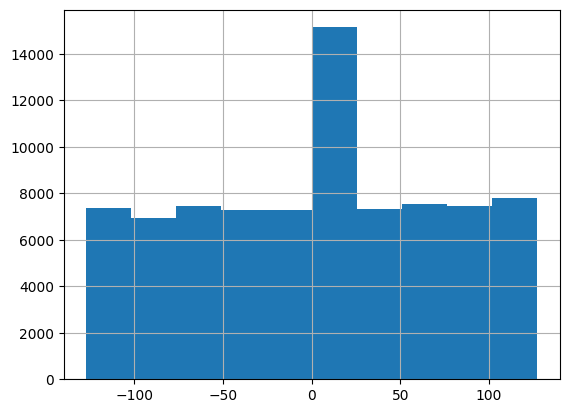

In [ ]:
# prompt: print summary of min, max and histogram of signed_tof_bin values

print(df_events['signed_tof_bin'].describe())
df_events['signed_tof_bin'].hist()


Main Header Values


In [ ]:
RECORD_BYTES     = 512
MAIN_HDR_RECORDS = 17

# 1. load main header
#with open('1SEC_CTAC.list','rb') as f:
#with open('/content/QA_Src_Offset_CTAC.list','rb') as f:
with open('/content/randoms_500k_a.list','rb') as f:

    f.seek(RECORD_BYTES)
    main_hdr = f.read(MAIN_HDR_RECORDS * RECORD_BYTES)

# 2. tofTstampScale @ 0x0038–0x0039
tofTstampScale = int.from_bytes(main_hdr[0x0038:0x003A], 'big')
print("tofTstampScale (ps/bin):", tofTstampScale)

# 3. nXtalRows @ 0x0066–0x0067
nXtalRows = int.from_bytes(main_hdr[0x0066:0x0068], 'big')
print("nXtalRows:", nXtalRows)



tofTstampScale (ps/bin): 84
nXtalRows: 40


## My additional prompt, 20250511:

How do I print the Main Header 0x003a: tofTstampScale value from my .list file?
Where is the Extended Main Header located?
How do I print Extended Main Header 0x07D0: coinc_half_window_bins (shown in memory map as c_h_w_b ) ?
I am confused by the listPrint utility output:
Filename = d:\temp\500KC_1bc3.list
List File Header ( size = 9744 ):
nevents_buffer = 100000
magicNumber    = 0x5874616c (Xtal)
type           = 16
singles        = 0
auxTimestamps  = 0
mhdrSize       = 8704
shdrSize       = 512
deLength       = 0
deType         = 16
dePad          = 0
190: PROMPT: xa(172) xb(538) tof(-1) za(7) zb(24) lea(138) leb(132)
191: PROMPT: xa(56) xb(219) tof(2) za(7) zb(13) lea(126) leb(128)
192: PROMPT: xa(86) xb(515) tof(45) za(16) zb(20) lea(123) leb(122)
194: PROMPT: xa(153) xb(459) tof(-91) za(7) zb(22) lea(120) leb(130)
195: PROMPT: xa(103) xb(459) tof(-62) za(36) zb(22) lea(128) leb(130)
I would think auxTimestamps would =1 indicating "Flag to indicate if timestamps are stored in the AUX data (8
bits)". It appears to me that timestamps are stored in bits 26:20, (bit 27 sign bit). Where else would we get tof data?


## Gemini:

Let's clarify these points and how to access the specific header values you're interested in.

## 1. Printing Main Header 0x3C: tofTstampScale

You are correct that the tofTstampScale is at offset 0x3C (decimal 60) within the main header block. The main header block itself starts after the listview header (which is 512 bytes long).

Absolute File Offset: 512 (listview) + 0x3C (offset within main) = 512 + 60 = 572 bytes from the beginning of the file.

Our current parse_headers_fixed function already does this:

    # --- Read Main Header and Extract tofTstampScale ---
    f.seek(LISTVIEW_SIZE) # Start of Main Header (LISTVIEW_SIZE is 512)
    main_header_bytes = f.read(MAIN_HEADER_SIZE_ASSUMED) # Reads the whole main header block
    headers['main_header'] = main_header_bytes
    if len(main_header_bytes) < MAIN_HEADER_SIZE_ASSUMED:
         # ... error handling ...
    else:
        tof_scale_offset = 0x3C # Offset within the main_header_bytes block
        try:
            # Unpacks from main_header_bytes, which is the block read from file offset 512
            headers['tofTstampScale'], = struct.unpack('>f', main_header_bytes[tof_scale_offset:tof_scale_offset+4])
            print(f"Extracted tofTstampScale from Main Header: {headers['tofTstampScale']} ps/bin")
        # ... error handling ...

So, the value headers['tofTstampScale'] that the script already calculates and prints is precisely this value.



## 2. Extended Main Header Location

The "Extended Main Header" isn't a single, separate block in the way the "Main Header" or "Sub Header" are sometimes conceived. Instead, the "Main Header Format" spanning multiple "pages" (which are typically 512-byte blocks).

## Page 1: Starts at file offset 512.

This is the "original" main header.
## Subsequent Pages (Extended Main Header):

 If the main header information exceeds what fits in the first 512-byte block (after the listview header), it continues into subsequent 512-byte blocks. The readlist.m script and our Python adaptation (based on MAIN_HEADER_RECORDS = 17) assume the main header information (including any "extended" parts) occupies 17 * 512 = 8704 bytes immediately following the listview header.

So, the "Extended Main Header" content is part of the headers['main_header'] byte string that parse_headers_fixed reads. It's not a distinct block at a different primary file offset; it's a continuation of the main header information.

## 3. Printing Extended Main Header 0x07D0:

coinc_half_window_bins (c_h_w_b)
The address 0x07D0 refers to an offset within the overall main header structure as defined in Appendix A.
Appendix A, page A-10 shows "Extended Main Header File Format: Memory Map - page 4, cont."
The field c_h_w_b (which represents coinc_half_window_bins) is shown at address 07Dx where x is 0. So, its offset within "page 4" (which is mh[3] in the documentation's array notation) is 0x07D0 - 0x0600 = 0x1D0 (since page 4 starts at relative offset 0x600 within the extended header pages).
More simply, if you consider the entire main header block as one continuous memory region:
The documentation shows memory map pages for mh[0] (original/extended page 1, starts at file offset 512), mh[1] (extended page 2), ..., mh[15] (extended page 16).
0x07D0 is the absolute offset within the conceptual 17*512 byte main header data.
The main_header_bytes variable in our Python script holds this entire 8704-byte block.

## To print it:

# Inside or after parse_headers_fixed, once headers['main_header'] is populated

main_header_bytes = headers.get('main_header')
chwb_offset_in_main_header = 0x07D0 # From Appendix A map

if main_header_bytes and len(main_header_bytes) >= (chwb_offset_in_main_header + 2): # +2 for unsigned short
    try:
        # c_h_w_b is shown as unsigned short (2 bytes) in diagrams
        # and the Matlab header indicates it's coinc_half_window_bins
        # (from your previous file, listPrint for COLL_QA_2981.list did not show it directly,
        # but the memory map for c_h_w_b is on page A-10 at 0x07D0).
        # The actual variable name `coinc_half_window_bins` is defined as `unsigned short`
        # in the `xtal.h` equivalent from Philips for this data type.
        coinc_half_window_bins, = struct.unpack('>H', main_header_bytes[chwb_offset_in_main_header : chwb_offset_in_main_header + 2])
        print(f"Extended Main Header 0x07D0 (coinc_half_window_bins): {coinc_half_window_bins}")
        headers['coinc_half_window_bins'] = coinc_half_window_bins
    except struct.error as e:
        print(f"Error unpacking coinc_half_window_bins: {e}", file=sys.stderr)
    except IndexError:
        print(f"Error: Main header too short to read coinc_half_window_bins at offset {chwb_offset_in_main_header}", file=sys.stderr)
else:
    print("Main header not read or too short to access coinc_half_window_bins.", file=sys.stderr)

    


## TOF Data (Word 0, Bits 20-27):

You correctly identified that bits 20-27 of the first data word are for the Time-of-Flight measurement.
This is a direct measurement of the time difference between photon arrivals for a specific coincidence event. It's used for TOF-PET reconstruction to better localize the annihilation along the LOR.
It is not the same as the overall timestamp of when the event happened during the scan.
